In [2]:
import numpy as np
import ast
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
import dill
import requests
import xmltodict
import cvxpy as cp
import itertools
from scipy.special import logsumexp

%matplotlib inline
# sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/dev/vivarium-ecoli'))

from ecoli.processes.metabolism_redux_classic import NetworkFlowModel, FlowResult
from ecoli.library.schema import numpy_schema, bulk_name_to_idx, listener_schema, counts
from ecoli.processes.registries import topology_registry
TOPOLOGY = topology_registry.access("ecoli-metabolism-redux")


In [3]:
# create a function to deal with non-homogeous dtype of columns. mixture of strings and lists
def string_to_list(s):
    try:
        return np.array(ast.literal_eval(s))  # Safely convert string to array
    except (ValueError, SyntaxError):
        return np.array(s)  # Return as array if object is not a list and conversion fails (e.g., NaN values)

### Load Experiments

In [4]:
time = '400'
date = '2025-01-13'
experiment = 'metabolism-redux-classic-BASAL_NEW-modified_process_new_rxn_name'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output_new = output['agents']['0']
fba_new = output_new['listeners']['fba_results']
mass_new = output_new['listeners']['mass']
bulk_new = pd.DataFrame(output_new['bulk'])

In [5]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent_new = dill.load(f)
f.close()

In [6]:
time = '400'
date = '2025-01-13'
experiment = 'metabolism-redux-classic-BASAL_OLD-modified_process_new_rxn_name'
entry = f'{experiment}_{time}_{date}'
folder = f'out/cofactors/{entry}/'

output = np.load(folder + '0_output.npy',allow_pickle='TRUE').item()
# output = np.load(r"out/geneRxnVerifData/output_glc.npy", allow_pickle=True, encoding='ASCII').tolist()
output = output['agents']['0']
fba = output['listeners']['fba_results']
mass = output['listeners']['mass']
bulk = pd.DataFrame(output['bulk'])

In [7]:
f = open(folder + 'agent_steps.pkl', 'rb')
agent = dill.load(f)
f.close()

### Create Dataframe

In [8]:
# create simulation flux dataframe - OLD
self = agent['ecoli-metabolism-redux-classic'] #self of metabolism_redux_classic class
reaction_names = agent['ecoli-metabolism-redux-classic'].reaction_names

sim_fluxes = pd.DataFrame(fba["estimated_fluxes"])
target_fluxes = pd.DataFrame(fba["target_kinetic_fluxes"])

sim_fluxes.columns = reaction_names
sim_fluxes = sim_fluxes.iloc[1:,] # remove first row (NAs) of the dataframe
target_fluxes = target_fluxes.iloc[1:,] # remove first row (NAs) of the dataframe

In [9]:
# create simulation flux dataframe - NEW
self_new = agent_new['ecoli-metabolism-redux-classic'] #self of metabolism_redux_classic class
reaction_names_new = agent_new['ecoli-metabolism-redux-classic'].reaction_names

sim_fluxes_new = pd.DataFrame(fba_new["estimated_fluxes"])
target_fluxes_new = pd.DataFrame(fba_new["target_kinetic_fluxes"])

sim_fluxes_new.columns = reaction_names_new
sim_fluxes_new = sim_fluxes_new.iloc[1:,] # remove first row (NAs) of the dataframe
target_fluxes_new = target_fluxes_new.iloc[1:,] # remove first row (NAs) of the dataframe

In [10]:
fba_new_reaction_ids = agent['ecoli-metabolism-redux-classic'].parameters["fba_new_reaction_ids"]
fba_reaction_ids_to_base_reaction_ids = self._parameters['fba_reaction_ids_to_base_reaction_ids']

In [24]:
#### ALL REACTION FLUX #####
sim_fluxes_avg = sim_fluxes.mean(axis=0)
sim_fluxes_avg_new = sim_fluxes_new.mean(axis=0)

# set up df
df = pd.DataFrame({'sim_fluxes_avg': sim_fluxes_avg, 'sim_fluxes_avg_new': sim_fluxes_avg_new})
df['is_new'] = 'Old Reactions'
df.loc[fba_new_reaction_ids, 'is_new'] = 'New Reactions'  

# log flux and + e-6
df1 = df.copy()
df1.sim_fluxes_avg += 10**-6
df1.sim_fluxes_avg_new += 10**-6

df1.sim_fluxes_avg = np.log10(df1.sim_fluxes_avg)
df1.sim_fluxes_avg_new = np.log10(df1.sim_fluxes_avg_new)

#### KINETICALLY CONSTRAINED REACTION FLUX #####
# get target flux for the kinetically constrained reactions
target_kinetic_flux = fba['target_kinetic_fluxes'][1:]
target_kinetic_flux_new = fba_new['target_kinetic_fluxes'][1:] #atoms/second
kinetic_reactions = agent['ecoli-metabolism-redux-classic'].kinetic_constraint_reactions

# get average target flux for the kinetically constrained reactions
target_kinetic_flux = np.array(target_kinetic_flux).mean(axis=0)
target_kinetic_flux_new = np.array(target_kinetic_flux_new).mean(axis=0)

# get estimated flux for the kinetically constrained reactions
df_kinetic = df.loc[kinetic_reactions].copy()
df_kinetic['target'] = target_kinetic_flux
df_kinetic['target_new'] = target_kinetic_flux_new

# deal with 0 fluxes and math.log10 on all fluxes
df_kinetic.sim_fluxes_avg_new += 10**-6
df_kinetic.sim_fluxes_avg     += 10**-6
df_kinetic.target             += 10**-6
df_kinetic.target_new         += 10**-6

df_kinetic.sim_fluxes_avg_new = np.log10(df_kinetic.sim_fluxes_avg_new)
df_kinetic.sim_fluxes_avg     = np.log10(df_kinetic.sim_fluxes_avg)
df_kinetic.target             = np.log10(df_kinetic.target)
df_kinetic.target_new         = np.log10(df_kinetic.target_new)

# add in a column indicating Eucleanian distance of two scatter plot
df_kinetic['distance'] = np.sqrt((df_kinetic.target_new - df_kinetic.target)**2 +
                               (df_kinetic.sim_fluxes_avg_new - df_kinetic.sim_fluxes_avg)**2)
# normalize Eucleanian distance to be between 0 and 1
df_kinetic['distance'] = (df_kinetic['distance']-np.min(df_kinetic['distance']))/ \
                         (np.max(df_kinetic['distance'])-np.min(df_kinetic['distance']))

# set up plotly parameters
category_colors = {
    'Old Reactions': "purple",
    'New Reactions': "yellow",
}

In [12]:
df1

,sim_fluxes_avg,sim_fluxes_avg_new,is_new
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,-6.000000,-6.000000,Old Reactions
1.1.1.127-RXN,-6.000000,-6.000000,Old Reactions
1.1.1.127-RXN (reverse),-6.000000,-6.000000,Old Reactions
1.1.1.215-RXN (reverse),-6.000000,-6.000000,Old Reactions
1.1.1.251-RXN,-6.000000,-6.000000,Old Reactions
...,...,...,...
XYLONATE-DEHYDRATASE-RXN,-6.000000,-6.000000,Old Reactions
XYLULOKIN-RXN-CPD-24961/ATP//XYLULOSE-5-PHOSPHATE/ADP/PROTON.47.,-6.000000,-6.000000,Old Reactions
YIAE1-RXN (reverse),-6.000000,-6.000000,Old Reactions
glycogen-monomer-extension,3.998043,4.005443,Old Reactions


### Plot Old and New Fluxome and Extract New Reactions with Zero Flux

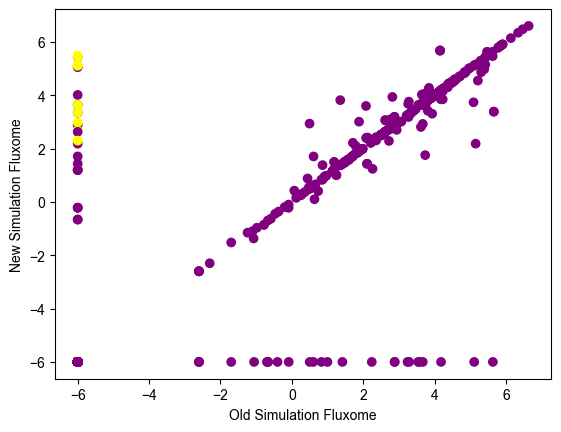

In [30]:
%matplotlib inline
plt.scatter(df1.sim_fluxes_avg, df1.sim_fluxes_avg_new, color = df1.is_new.map(category_colors))
plt.xlabel('Old Simulation Fluxome')
plt.ylabel('New Simulation Fluxome')
plt.show()

In [67]:
# check how many of each are kinetic reactions
df1['is_kinetic'] = False
df1.loc[kinetic_reactions, 'is_kinetic'] = True

zero_flux_new = df1[(df1.sim_fluxes_avg_new == -6) & (df1.is_new == 'New Reactions')]
with_flux_new = df1[(df1.sim_fluxes_avg_new != -6) & (df1.is_new == 'New Reactions')]
new_kinetic_rxn = df1[(df1.is_new == 'New Reactions') & (df1.is_kinetic == True)]

print(f'Number of new reactions with no flux: {len(zero_flux_new)}')
print(f'Number of new reactions with flux: {len(with_flux_new)}')
print(f'Number of new reactions with no flux that are kinetic: {len(zero_flux_new[zero_flux_new.is_kinetic == True])}')
print(f'Number of new reactions with flux that are kinetic: {len(with_flux_new[with_flux_new.is_kinetic == True])}')
print(f'Number of new reactions that are kinetic: {len(new_kinetic_rxn)}')

Number of new reactions with no flux: 554
Number of new reactions with flux: 11
Number of new reactions with no flux that are kinetic: 43
Number of new reactions with flux that are kinetic: 0
Number of new reactions that are kinetic: 43


In [68]:
with_flux_new

,sim_fluxes_avg,sim_fluxes_avg_new,is_new,is_kinetic
2.7.3.9-RXN,-6.0,5.479422,New Reactions,False
GLUC1PURIDYLTRANS-RXN,-6.0,2.672266,New Reactions,False
GLUCOSAMINE-6-P-DEAMIN-RXN-CPD-13469/WATER//AMMONIUM/FRUCTOSE-6P.38. (reverse),-6.0,2.977211,New Reactions,False
GLUTCYSLIG-RXN,-6.0,3.345733,New Reactions,False
ISOCIT-CLEAV-RXN,-6.0,5.082974,New Reactions,False
MALSYN-RXN,-6.0,5.118174,New Reactions,False
PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54. (reverse),-6.0,1.193681,New Reactions,False
RXN0-2501,-6.0,2.296446,New Reactions,False
RXN0-313,-6.0,5.437234,New Reactions,False
TRANS-RXN0-574-GLC//GLC.9.,-6.0,5.106291,New Reactions,False


| FBA Reaction ID | Related Reactions| gene| Notes |
| :---: | :---: | :---: |  :---: | 
| 2.7.3.9-RXN | [RXN-17354, RXN-17355]| ptsI |Enzyme I of phosphotransferase system, acting on histidine residue in  phosphocarrier proteins of low molecular mass (9.5kDa) involved in <b> bacterial sugar transport </b>|
| GLUC1PURIDYLTRANS-RXN	 | None | galU | Intermediary metabolism involved in biosynthesiss of polysaccharide moieties in the <b> cell wall </b> |
|ISOCIT-CLEAV-RXN| None| aceA| Part of the <b> glyoxylate cycle </b>. Cleaves isocitrate in one direction, condenses glyoxalate and succinate in the other direction|
|MALSYN-RXN| None| aceB, glcB| Part of the <b> glyoxylate cycle </b> and pathway <b> glycolate and glyoxylate degradation II</b>. Enzyme catalyses condensation of acetyl-CoA with glyoxylate to form (S)-malate|
|*PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54. (reverse)| None| yfeX, efeB, hemH| The last reaction in <b>protoheme/heme biosynthesis </b>. Only catalysed in reverse direction. Pathways: heme b biosynthesis V (aerobic) and heme b biosunthesis II (oxygen-independent)|
|RXN0-2501 | None| clcB, clcA <i>( clcA not in WCM gene excel)</i>| Chloride:proton antiport. <b>acid resistance</b>|
|RXN0-313 | Nobe| fsaB, fsaA| <b> cleavage of fructose-6-phosphate </b> into two three-carbon molecules. Contributes to the interconversion of sugars and ensures a balance of three-carbon intermediates|
|*TRANS-RXN0-574-GLC//GLC.9.|TRANS-RXN0-575 (maltose transport by malX)| malX| <b> transport of D-glucopyranose</b>. Sugar diffusion from periplasm to cytosol|
|*TRANS-RXN0-574-GLC//Glucopyranose.19.|TRANS-RXN0-575 (maltose transport by malX)| malX|Glucose (GLC) refers to the simple sugar molecule, while "glucopyranose" describes the ring-shaped structure that glucose forms when it cyclizes in solution. So this reaction is saying that glucose get transported in and forms a ring-shaped structure in the cytosol.|

<p> <span style='background :#fcd1d7' color = 'b' > PROTOHEMEFERROCHELAT-RXN in periplasm is catalysed by CPLX0-7810(efeB) which is not a new gene/reaction. PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL] is catalyzed by new enzymes/genes (yfeX and hemH).   </span> 

<p> <span style='background :#fcd1d7' color = 'b' > TRANS-RXN0-574 is interesting because there are other reactions with minor changes but aren't getting used. Why?</span> 

In [82]:
GLC_trans = ["TRANS-RXN0-574", "TRANS-RXN0-574-ALPHA-GLUCOSE//ALPHA-GLUCOSE.29.", "TRANS-RXN0-574-ALPHA-GLUCOSE//Glucopyranose.29.",
             "TRANS-RXN0-574-GLC//GLC.9.", "TRANS-RXN0-574-GLC//Glucopyranose.19.", "TRANS-RXN0-574-Glucopyranose//ALPHA-GLUCOSE.29.",
             "TRANS-RXN0-574-Glucopyranose//GLC.19.", "TRANS-RXN0-574-Glucopyranose//Glucopyranose.29."]
Protoheme_rxn = ["PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54.",
                 "PROTOHEMEFERROCHELAT-RXN[CCO-CYTOSOL]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.54. (reverse)",
                 "PROTOHEMEFERROCHELAT-RXN[CCO-PERI-BAC]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.55.",
                 "PROTOHEMEFERROCHELAT-RXN[CCO-PERI-BAC]-PROTOHEME/PROTON//PROTOPORPHYRIN_IX/FE+2.55. (reverse)"]

df1.loc[GLC_trans]

,sim_fluxes_avg,sim_fluxes_avg_new,is_new,is_kinetic
TRANS-RXN0-574,-6.0,-6.000000,New Reactions,False
TRANS-RXN0-574-ALPHA-GLUCOSE//ALPHA-GLUCOSE.29.,-6.0,-6.000000,New Reactions,False
TRANS-RXN0-574-ALPHA-GLUCOSE//Glucopyranose.29.,-6.0,-6.000000,New Reactions,False
TRANS-RXN0-574-GLC//GLC.9.,-6.0,5.106291,New Reactions,False
TRANS-RXN0-574-GLC//Glucopyranose.19.,-6.0,3.637629,New Reactions,False
TRANS-RXN0-574-Glucopyranose//ALPHA-GLUCOSE.29.,-6.0,-6.000000,New Reactions,False
TRANS-RXN0-574-Glucopyranose//GLC.19.,-6.0,-6.000000,New Reactions,False
TRANS-RXN0-574-Glucopyranose//Glucopyranose.29.,-6.0,-6.000000,New Reactions,False


In [102]:
zero_flux_new_fba_id  = zero_flux_new.index
zero_flux_new_base_id = [fba_reaction_ids_to_base_reaction_ids[id] for id in zero_flux_new_fba_id]

In [103]:
NOTEBOOK_DIR = f'notebooks/Heena notebooks/Metabolism_New Genes'
df_zero = pd.DataFrame({"fba_id":zero_flux_new_fba_id, "base_id": zero_flux_new_base_id})
df_zero.to_csv(os.path.join(NOTEBOOK_DIR,'New Reactions with Zero Flux.csv'), index=False)